In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image

In [2]:
import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from camb import model, initialpower

### >>> Difference: I use H0 = 67, Ross uses 100

In [3]:
# a = 1/(1+z)
def hubble_z(z): # Flat universe: omega_k = 0
    hubble_0 = 67.74 # km/sec/Mpc
    Omega_m = .3089
    Omega_L = .6911
    H_z = np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_L))
    return H_z

hubble_z(2.0)

203.57419733021177

In [4]:
def chi_z(z_max):
    c = 3.0*(10**5) # km/sec 
    integrand = lambda z: c / hubble_z(z)
    chi_z = scipy.integrate.quad(integrand, 0, z_max)
    return chi_z[0]

chi_z(2.0)

5316.055934317975

### >>> Agree with Ross again with little h definition

In [5]:
h = .6774
z_values = np.linspace(0, 1, 100)
chi_values = [chi_z(redShift) for redShift in z_values]

z_chi_interp = InterpolatedUnivariateSpline(chi_values, z_values, k=5)

def z_chi(chi):
    z_val = z_chi_interp(chi)
    return z_val

#check with ned wright site
print(z_chi(100/h))
print(z_chi(1000/h))
print(z_chi(1317/h))
print(z_chi(1945/h))  
print(z_chi(2871/h))

0.033596540874348525
0.36557790249864985
0.49916771321280085
0.8005337261309369
1.3746030727634206


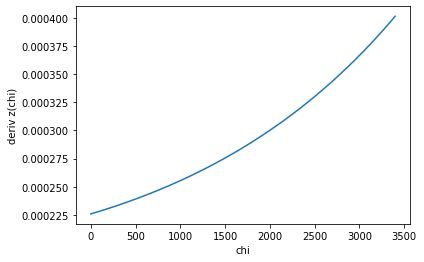

In [6]:
z_chi_deriv = z_chi_interp.derivative()

z_chi_deriv_vals = [z_chi_deriv(chi) for chi in chi_values]

plt.plot(chi_values, z_chi_deriv_vals)
plt.xlabel('chi')
plt.ylabel('deriv z(chi)')
plt.show()

### We agree up to this point. 

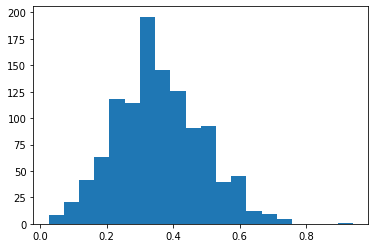

In [20]:
# Pull in the data and make into pandas dataframe 

qry_PanSTARRS_Data_All = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

connPAN = sqlite3.connect('/Users/megantabbutt/CosmologyDataProducts/' 
                          + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ = pd.read_sql(qry_PanSTARRS_Data_All, con=connPAN)
connPAN.close()
#PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

zBest = []
for i in PanSTARRSNEW_GoodZ.iterrows(): #.iterrows() returns a tuple (immutable object)
    if i[1]['zSN'] >= 0:
        zBest.append(i[1]['zSN'])
    else:
        zBest.append(i[1]['zHost'])
        
if PanSTARRSNEW_GoodZ.shape[0] == len(zBest):
    PanSTARRSNEW_GoodZ['zBest'] = zBest

bin_num = 20

plt.hist(PanSTARRSNEW_GoodZ['zBest'], bins=bin_num)
plt.show()

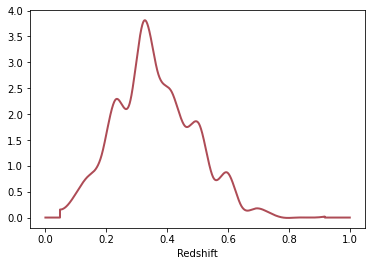

In [21]:
bin_width = (PanSTARRSNEW_GoodZ['zBest'].max() 
             - PanSTARRSNEW_GoodZ['zBest'].min())/bin_num

Sne_z_all_hist = np.histogram(PanSTARRSNEW_GoodZ['zBest'], bins=bin_num)

Sne_z_all_bin_centers = 0.5 * (Sne_z_all_hist[1][1:]+ Sne_z_all_hist[1][:-1])

Sne_z_all_hist_norm = Sne_z_all_hist[0] / sum(Sne_z_all_hist[0]) / bin_width

n_sne_interpolated = interpolate.interp1d(Sne_z_all_bin_centers, Sne_z_all_hist_norm, kind='cubic', bounds_error=False,
                                          fill_value=0.0)

z_values = np.linspace((Sne_z_all_bin_centers.min()), (Sne_z_all_bin_centers.max()), num=bin_num)

z_values = np.linspace(0, 1, num=1000000)

plt.plot(z_values, n_sne_interpolated(z_values), label="Interpolation", c="#8c000f", alpha=.7, lw=2)
plt.xlabel("Redshift")
plt.show()

### Kinda agree here?  ^^^ question about oscillation in mine, maybe should smooth?

(0.9957766778185958, 4.544448573141761e-12)


/Users/megantabbutt/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  


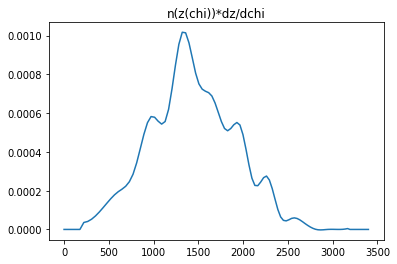

In [22]:
def quad_one_dim(integrand, limit_min, limit_max):
    integral = scipy.integrate.quad(integrand, limit_min, limit_max, epsrel=10**-12, epsabs=10**-12, limit=5000)  
    return integral

# n(z) dz/dx integral over x
normalization = quad_one_dim((lambda x: n_sne_interpolated(z_chi(x)) * z_chi_deriv(x)), chi_z(0.0), chi_z(1.0))
print(normalization)

intgrand = [(n_sne_interpolated(z_chi(x)) * z_chi_deriv(x)) for x in chi_values]

plt.plot(chi_values, intgrand)
plt.title('n(z(chi))*dz/dchi')
plt.show()

### We still agree here

Note: redshifts have been re-sorted (earliest first)


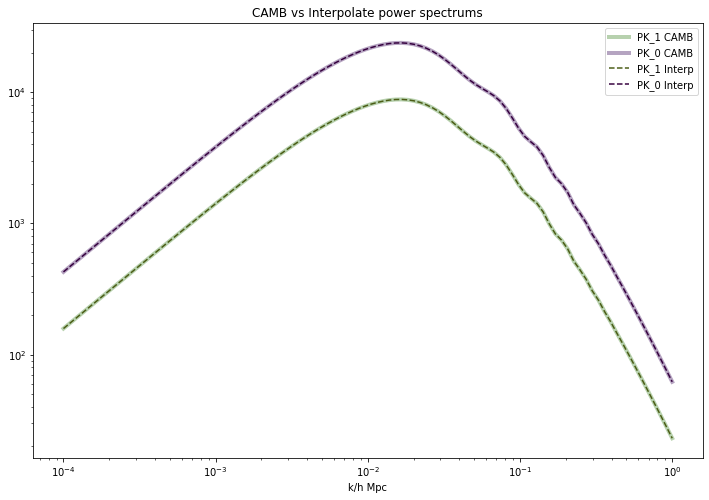

In [23]:
ombh2=0.0225
omch2=0.1188
ns=.96

#Now get matter power spectra at redshift 0 and 1.0
params = camb.CAMBparams()
params.set_cosmology(H0=67.74, ombh2=ombh2, omch2=omch2)
params.InitPower.set_params(ns=ns)

#Note non-linear corrections couples to smaller scales than you want
params.set_matter_power(redshifts=np.linspace(0.0, 1.0, num = 100), kmax=2.0)

#Linear spectra
params.NonLinear = model.NonLinear_none
results = camb.get_results(params)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 100)

matter_power_spectrum = interpolate.interp2d(kh, z, pk, kind='quintic')

# Plot the matter power spectrum from CAMB and the interpolation
plt.figure(figsize=(12, 8))
kh_list = np.logspace(-4.0, 0, num=100)
z_list = np.linspace(min(z), max(z), num=100)

plt.loglog(kh, pk[-1,:], color='#88b378', ls = "-", label="PK_1 CAMB", linewidth=4, alpha=.6)
plt.loglog(kh, pk[0,:], color='#856798', ls = "-", label="PK_0 CAMB", linewidth=4, alpha=.6)

plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[-1,:], color='#4b5d16', ls = "--", label="PK_1 Interp")
plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[0,:], color='#36013f', ls = "--", label="PK_0 Interp")

plt.xlabel('k/h Mpc')
#plt.xlim(11**-4, 2)
plt.legend(loc = "upper right")
plt.title("CAMB vs Interpolate power spectrums")
plt.show()

### Can't check matter power spec with ross, but this matches literature... So should be right... 

### From here on out just copy ross's code but change to be applicable to this notebook... Pray to Hubble

In [24]:
def j0(arg):
    return scipy.special.jv(0, arg)

def powerChi(chi, theta):
    h=0.6774
    integrad = lambda k: k * matter_power_spectrum(k*h, z_chi(chi))[0]*j0(k*chi*theta)
    powint = scipy.integrate.quad(integrad, kmin, kmax, epsrel=10**-8, epsabs=10**-8, limit=5000)
    return powint[0]/(2*np.pi)
    #return powint[0]

def g2(chi):
    nn = (n_sne_interpolated(z_chi(chi)) * z_chi_deriv(chi))
    return nn

def ggtheta(theta):
    chi_min = chi_z(0.01)
    chi_max = chi_z(0.9)
    b1=1
    b2=1
    h = .6774
    integrand = lambda chi: g2(chi)**2 * powerChi(chi, theta) *((1.0/h)**3)*b1*b2
    result = scipy.integrate.quad(integrand, chi_min, chi_max, epsrel=10**-8, epsabs=10**-8, limit=5000)
    return result[0]

In [25]:
kmin = kh.min()*h
kmax = kh.max()*h


kk = 0.1
print ('j0',j0(chi_z(0.5)*kk*0.1*180/np.pi))
print ('g2',g2(chi_z(0.5)))

#print ('powerchi', powerChi(chi_z(0.5),0.1*180/np.pi))
#print ('theta=0.1 deg',ggtheta(0.1*np.pi/180.))
#print ('theta=0.5 deg',ggtheta(0.5*np.pi/180.))
#print ('theta=1.0 deg',ggtheta(1.0*np.pi/180.))

j0 -0.02093102339919632
g2 0.000549335538763485


In [26]:
theta_array=[0.02,0.06,0.1,0.3,0.5,0.7,1.0]

gg_values = []
for theta in theta_array:
    gg_val = ggtheta(theta*np.pi/180.)
    print(theta, "     ", gg_val)
    gg_values.append(gg_val)

gg_values

0.02       0.07167118329990588
0.06       0.0680820335545131
0.1       0.06163829397516894
0.3       0.026329048905335092
0.5       0.014746111078447078
0.7       0.008885773401750854
1.0       0.00471580383842887


[0.07167118329990588,
 0.0680820335545131,
 0.06163829397516894,
 0.026329048905335092,
 0.014746111078447078,
 0.008885773401750854,
 0.00471580383842887]

In [27]:
print(gg_values)
print(theta_array)

[0.07167118329990588, 0.0680820335545131, 0.06163829397516894, 0.026329048905335092, 0.014746111078447078, 0.008885773401750854, 0.00471580383842887]
[0.02, 0.06, 0.1, 0.3, 0.5, 0.7, 1.0]


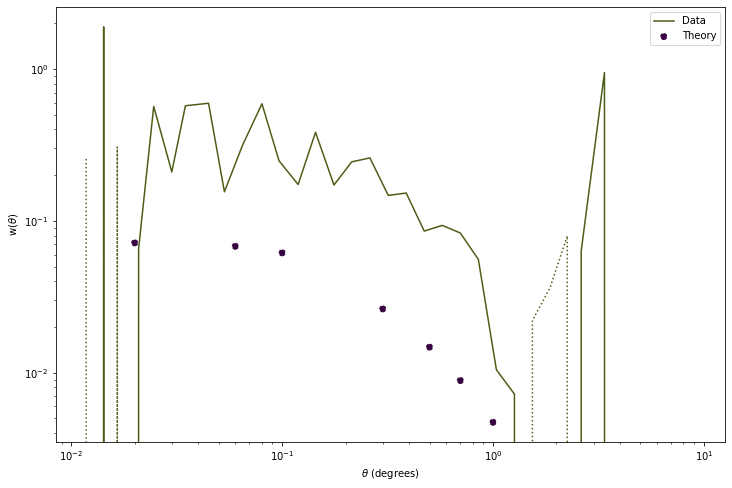

In [28]:
PanSTARRS_Data = pd.read_csv('/Users/megantabbutt/CosmologyDataProducts/' 
                             + 'PanSTARRS_AutoCorr_Plot_Results_df_100000000.csv', index_col=0)

r_PanSTARRS_Full = np.array(PanSTARRS_Data['r_PanSTARRS_Full'])
xi_PanSTARRS_Full = np.array(PanSTARRS_Data['xi_PanSTARRS_Full'])

plt.figure(figsize=(12, 8))

plt.plot(r_PanSTARRS_Full, xi_PanSTARRS_Full, color='#4b5d16', label="Data")
plt.plot(r_PanSTARRS_Full, -xi_PanSTARRS_Full, color='#4b5d16', ls=':')

plt.scatter(theta_array, gg_values, color='#36013f', ls="--", label="Theory")

plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'w($\theta$)')
plt.legend(loc='upper right')
#plt.xlim([0.01,10])

plt.show()